In [4]:
from google.colab import drive
drive.mount('/content/drive')
import tensorflow as tf
import matplotlib.pyplot as plt
import os


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
train_dir = '/content/drive/MyDrive/data/train'
val_dir = '/content/drive/MyDrive/data/val'


In [6]:
import cv2
import numpy as np

def load_subset(directory, fraction=0.2):
    images, labels = [], []
    files = [file for file in os.listdir(directory) if file.endswith(('.jpg', '.jpeg', '.png'))]

    sample_size = int(len(files) * fraction)
    sampled_files = np.random.choice(files, sample_size, replace=False)

    for file in sampled_files:
        age = int(file.split('_')[0])
        img_path = os.path.join(directory, file)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (128, 128))
        img = img / 255.0
        images.append(img)
        labels.append(age)

    return np.array(images), np.array(labels)

train_images, train_labels = load_subset(train_dir, fraction=0.2)

def load_all_data(directory):
    images, labels = [], []
    for file in os.listdir(directory):
        if file.endswith(('.jpg', '.jpeg', '.png')):
            age = int(file.split('_')[0])
            img_path = os.path.join(directory, file)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (128, 128))
            img = img / 255.0
            images.append(img)
            labels.append(age)
    return np.array(images), np.array(labels)

val_images, val_labels = load_all_data(val_dir)

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(32)

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
model.compile(
    optimizer='adam',
    loss='mae',
    metrics=['mae']
)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    mode='min',
    verbose=1
)

In [13]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 13.0163 - mae: 13.0163 - val_loss: 12.0601 - val_mae: 12.0601
Epoch 2/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 13.1786 - mae: 13.1786 - val_loss: 11.9667 - val_mae: 11.9667
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 12.9758 - mae: 12.9758 - val_loss: 11.7962 - val_mae: 11.7962
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 12.8568 - mae: 12.8568 - val_loss: 11.8360 - val_mae: 11.8360
Epoch 5/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 12.6407 - mae: 12.6407 - val_loss: 11.7519 - val_mae: 11.7519
Epoch 6/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 12.9921 - mae: 12.9921 - val_loss: 11.6918 - val_mae: 11.6918
Epoch 7/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 12.6834 - mae: 12.6834 - val_loss: 11.5455 - val_mae: 11.5455
Epoch 8/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 12.3200 - mae: 12.3200 - val_loss: 11.5373 - val_mae: 11.5373
Epoch 9/

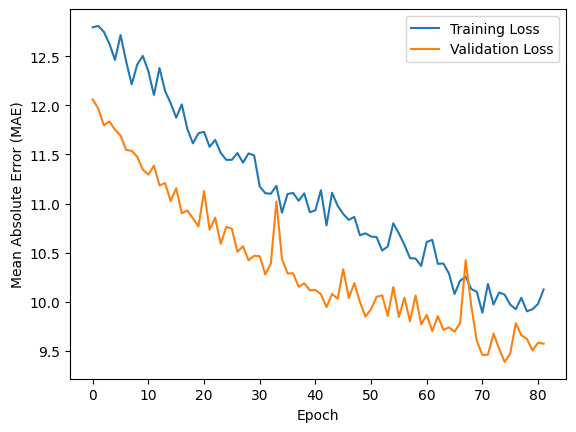

In [14]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.show()

In [15]:
val_loss, val_mae = model.evaluate(val_dataset)
print(f'Validation MAE: {val_mae:.2f}')

129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.4477 - mae: 9.4477
Validation MAE: 9.39


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Age: 22


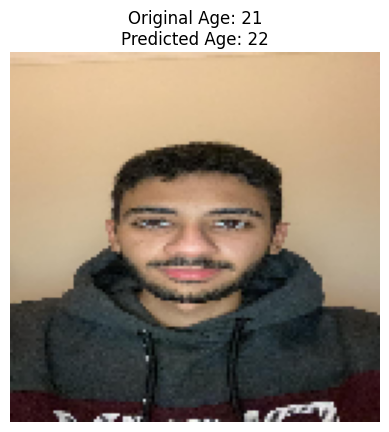

In [38]:
from tensorflow.keras.preprocessing import image

img_path = '/content/drive/MyDrive/Picture/yassin.jpg'
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

filename = img_path.split('/')[-1]
original_age = int(filename.split('_')[0])

predicted_age = model.predict(img_array)[0][0]
print(f'Predicted Age: {int(predicted_age)}')

plt.imshow(img)
plt.title(f'Original Age: {original_age}\nPredicted Age: {int(predicted_age)}')
plt.axis('off')
plt.show()
